# PVT

In [7]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import glob


In [5]:
home_dir = str(Path.home())
data_dir = os.path.join(home_dir, 'Box/CogNeuroLab/Wearables/data/')

In [93]:
pvt_files = glob.glob(data_dir + 'PVT/*/*/data.raw')
pvt_files_remote = glob.glob(data_dir + 'PVT/PVT_remote/*.csv')
pvt_files

['/Users/megmcmahon/Box/CogNeuroLab/Wearables/data/PVT/10011/20191024_1719_001/data.raw',
 '/Users/megmcmahon/Box/CogNeuroLab/Wearables/data/PVT/10012/20191018_1623_001/data.raw',
 '/Users/megmcmahon/Box/CogNeuroLab/Wearables/data/PVT/10014/20191111_1747_001/data.raw',
 '/Users/megmcmahon/Box/CogNeuroLab/Wearables/data/PVT/10023/20191111_1434_001/data.raw',
 '/Users/megmcmahon/Box/CogNeuroLab/Wearables/data/PVT/10024/20191105_1549_001/data.raw',
 '/Users/megmcmahon/Box/CogNeuroLab/Wearables/data/PVT/10025/20191205_1456_001/data.raw',
 '/Users/megmcmahon/Box/CogNeuroLab/Wearables/data/PVT/10033/20191107_1526_001/data.raw',
 '/Users/megmcmahon/Box/CogNeuroLab/Wearables/data/PVT/10035/20200207_1535_001/data.raw',
 '/Users/megmcmahon/Box/CogNeuroLab/Wearables/data/PVT/10038/20200122_1029_001/data.raw',
 '/Users/megmcmahon/Box/CogNeuroLab/Wearables/data/PVT/10045/20191204_1234_001/data.raw',
 '/Users/megmcmahon/Box/CogNeuroLab/Wearables/data/PVT/10049/20191202_1143_002/data.raw',
 '/Users/m

In [125]:
pvt = pd.read_csv(pvt_files[3], sep = ",", header = 0, names = ['id', 'isi', 'it', 'sp', 'st', 'rt', 'err', 'bp', 'fs', 'nr'], dtype = 'float')
pvt[pvt['fs'] == 1]

,id,isi,it,sp,st,rt,err,bp,fs,nr
13,13.0,7.428,70.478172,0.0,0.0,73.146568,0.0,0.0,1.0,0.0
66,66.0,8.102,418.190979,0.0,0.0,426.351471,0.0,0.0,1.0,0.0


In [169]:
def response_time(pvt, version):
    
    conditions = [
            (pvt['fs'] == 1),
            (pvt['nr'] == 1),
            (pvt['fs'] == 0) & (pvt['nr'] == 0)
        ]
    
    if version == 'inlab':
        values = [ 1, 65000, (pvt['rt'] - pvt['st']) ] # returns RT in seconds
    elif version == 'online':
        values = [ 1, 65000, pvt['Response.rt'] ] # returns RT in seconds
    else:
        print('invalid PVT version')

    pvt['RT'] = np.select(conditions, values)
        
    return pvt

def no_response(pvt_remote):
    pvt['nr'] = np.where(pvt['Response.rt'] > pvt['Interval_stimulus'], 1.0, 0.0)
    
    return pvt

def false_start(pvt_remote):
    pvt['fs'] = np.where(pvt['key_resp.keys'].isnull(), 0.0, 1.0)
    
    return pvt

In [170]:
pvt_results = []

for file in pvt_files: 
    subid = file.split('/data/PVT/')[1][0:5]
    pvt = pd.read_csv(file, sep = ",", header = 0, names = ['id', 'isi', 'it', 'sp', 'st', 'rt', 'err', 'bp', 'fs', 'nr'], dtype = 'float')
    pvt = response_time(pvt, 'inlab')
    pvt_results.append([subid, pvt['RT'].mean(), pvt['fs'].sum(), pvt['nr'].sum()])
    
for file in pvt_files_remote: 
    pvt = pd.read_csv(file, sep = ",")
    subid = pvt['Participant ID'][0]
    pvt = no_response(pvt)
    pvt = false_start(pvt)
    pvt = response_time(pvt, 'online')
    pvt_results.append([subid, pvt['RT'].mean(), pvt['fs'].sum(), pvt['nr'].sum()])
        
pvt_results = pd.DataFrame(pvt_results, columns = ['record_id', 'RT', 'FS', 'NR'])
pvt_results

,record_id,RT,FS,NR
0,10011,0.287571,0.0,0.0
1,10012,0.292187,3.0,0.0
2,10014,0.343802,6.0,0.0
3,10023,0.295579,2.0,0.0
4,10024,0.286903,1.0,0.0
5,10025,0.245413,1.0,0.0
6,10033,0.343700,0.0,0.0
7,10035,0.267186,1.0,0.0
8,10038,0.270828,2.0,0.0
9,10045,0.443086,1.0,0.0


In [171]:
pvt_results.to_csv(data_dir + 'PVT/pvt_results.csv')

Text(0.5, 1.0, 'PVT Mean Response Time')

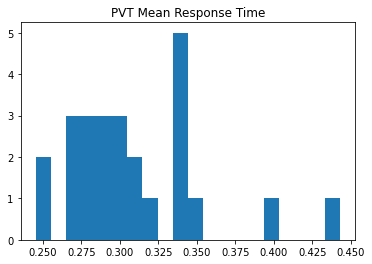

In [177]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(pvt_results['RT'][pvt_results['RT'] < 0.65], bins=20)
plt.title('PVT Mean Response Time')

Text(0.5, 1.0, 'PVT False Starts')

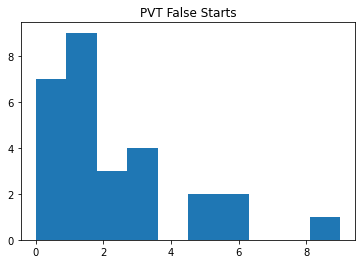

In [178]:
plt.hist(pvt_results['FS'], bins=10) #excluding 20127 as outlier
plt.title('PVT False Starts')

Text(0.5, 1.0, 'PVT No Responses')

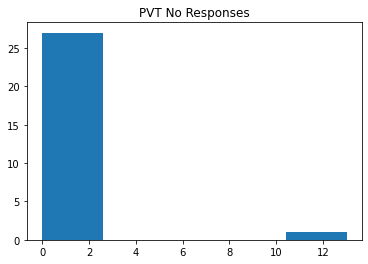

In [179]:
plt.hist(pvt_results['NR'], bins=5)
plt.title('PVT No Responses')